# Computing Square Adapted Wasserstein Distance 2 with Fitted Value Iteration

This notebook demonstrates how to compute the squared adapted Wasserstein distance using Fitted Value Iteration (FVI). The method leverages conditional density estimation, as described in the paper:

**"Learning conditional distributions on continuous spaces"**  
Cyril Bénézet, Ziteng Cheng, and Sebastian Jaimungal (2024).  
[arXiv:2406.09375](https://arxiv.org/abs/2406.09375)

We utilize a neural network-based approach to estimate conditional densities and train a deep Q-network (DQN) to approximate the adapted optimal transport distance. The codebase integrates various modules for sampling paths, building adapted trees, and solving the transport problem efficiently.

In this notebook, we will:
1. Generate sample paths from Brownian motion.
2. Estimate conditional densities.
3. Train the FVI algorithm to approximate the adapted Wasserstein distance.
4. Compute and compare the real adapted Wasserstein distance as a benchmarking value.

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

# Get the absolute path of src/ directory
notebooks_path = os.path.abspath(os.getcwd())  # Get the notebook’s current directory
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))

# Ensure src is in sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)  # Insert at the beginning to prioritize it

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import necessary modules
from Measure_sampling.Gen_Path_and_AdaptedTrees import generate_brownian_motion
from Conditional_density.CD_knn_NerualNet import train_conditional_density
from FVI.FVI import train_dqn_instance, train_dqn_instance_nonparam
from benchmark_value_gaussian.Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared

In [2]:
# Generate Brownian motion paths
n_data = 2000
time_steps = 20  # For example, t=0, t=1, t=2, t=3

scale_x = 1
scale_y = 0.5
x_init = 1
y_init = 2

In [3]:
# Define parameters
a, b = x_init, y_init
var_a, var_b = scale_x**2, scale_y**2
t = time_steps - 1

# Build mean and covariance matrices for both processes
a_vec, A_mat = build_mean_and_cov(t, mean_val=a, var_factor=var_a)
b_vec, B_mat = build_mean_and_cov(t, mean_val=b, var_factor=var_b)

# Compute adapted Wasserstein squared distance
distance_squared = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)
distance = np.sqrt(distance_squared)

print(f"Adapted Wasserstein Squared Distance: {distance_squared:.4f}")
print(f"Adapted Wasserstein Distance: {distance:.4f}")

Adapted Wasserstein Squared Distance: 66.5000
Adapted Wasserstein Distance: 8.1548


In [12]:
import numpy as np
import time
import pandas as pd

# Parameters
time_steps_list = list(range(16, 17))  # list(range(2, 12)) + [16]
n_data_dict = {t: 2000 for t in range(2, 16)}
n_data_dict.update({8: 2500, 9: 2500, 10: 3000, 11: 3000, 16: 4000})

n_opt_dict = {
    t: 50 if t <= 6 else 40 if t == 7 else 30 if t == 8 else 20 for t in time_steps_list
}

scale_x = 1
scale_y = 0.5
x_init = 1
y_init = 2

num_runs = 10
device = "cpu"  # Assuming CPU usage

# Storage for results
results = []

# Loop over time steps
for time_steps in time_steps_list:
    n_data = n_data_dict[time_steps]
    n_opt = n_opt_dict[time_steps]

    final_values = []
    run_times = []

    for i in range(num_runs):
        start_time = time.time()

        # Generate Brownian motion paths
        x_paths = generate_brownian_motion(
            num_paths=n_data, x_init=x_init, time_steps=time_steps, scale=scale_x
        )
        y_paths = generate_brownian_motion(
            num_paths=n_data, x_init=y_init, time_steps=time_steps, scale=scale_y
        )

        # Train DQN
        final_value, val_hist, loss_hist = train_dqn_instance(
            x_dim=1,
            y_dim=1,
            time_horizon=time_steps - 1,
            samplepath_x=x_paths,
            samplepath_y=y_paths,
            n_opt=n_opt,
            in_sample_size=25,
            device=device,
            discount=1,
            mem_size=3000,
            trunc_flag=True,
            n_iter=750,
        )

        elapsed_time = time.time() - start_time

        final_values.append(final_value)
        run_times.append(elapsed_time)

    # Compute statistics
    mean_final_value = np.mean(final_values)
    std_final_value = np.std(final_values)
    mean_run_time = np.mean(run_times)

    # Print results
    print(
        f"Time Steps: {time_steps}, Mean Final Value: {mean_final_value:.4f}, Std Dev: {std_final_value:.4f}, Avg Time: {mean_run_time:.4f}"
    )

    # Store results
    results.append([time_steps, mean_final_value, std_final_value, mean_run_time])

# Convert results to DataFrame and display
df_results = pd.DataFrame(
    results, columns=["Time Steps", "Mean Final Value", "Std Dev", "Avg Time (s)"]
)
print(df_results)

/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/FVI/utils.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_batch = torch.stack([torch.tensor(t, dtype=torch.float32) for t in batch.time])


Time step 15 Loss: 0.013977051561232657
Training took 20.21 seconds.
Number of NaN losses encountered: 0
Training took 22.30 seconds.
Number of NaN losses encountered: 0


/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/FVI/FVI.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_x = torch.tensor(x_est, dtype=torch.float32).reshape(-1, 1)
/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/FVI/FVI.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_y = torch.tensor(y_est, dtype=torch.float32).reshape(-1, 1)


Time step 14 Loss: 17.43930311203003
Training took 18.96 seconds.
Number of NaN losses encountered: 0
Training took 18.69 seconds.
Number of NaN losses encountered: 0
Time step 13 Loss: 15.75350489616394
Training took 20.01 seconds.
Number of NaN losses encountered: 0
Training took 19.89 seconds.
Number of NaN losses encountered: 0
Time step 12 Loss: 13.094772171974181
Training took 18.52 seconds.
Number of NaN losses encountered: 0
Training took 17.82 seconds.
Number of NaN losses encountered: 0
Time step 11 Loss: 11.625488758087158
Training took 17.71 seconds.
Number of NaN losses encountered: 0
Training took 17.55 seconds.
Number of NaN losses encountered: 0
Time step 10 Loss: 8.222693943977356
Training took 20.29 seconds.
Number of NaN losses encountered: 0
Training took 18.80 seconds.
Number of NaN losses encountered: 0
Time step 9 Loss: 6.431667923927307
Training took 20.18 seconds.
Number of NaN losses encountered: 0
Training took 19.48 seconds.
Number of NaN losses encountered:

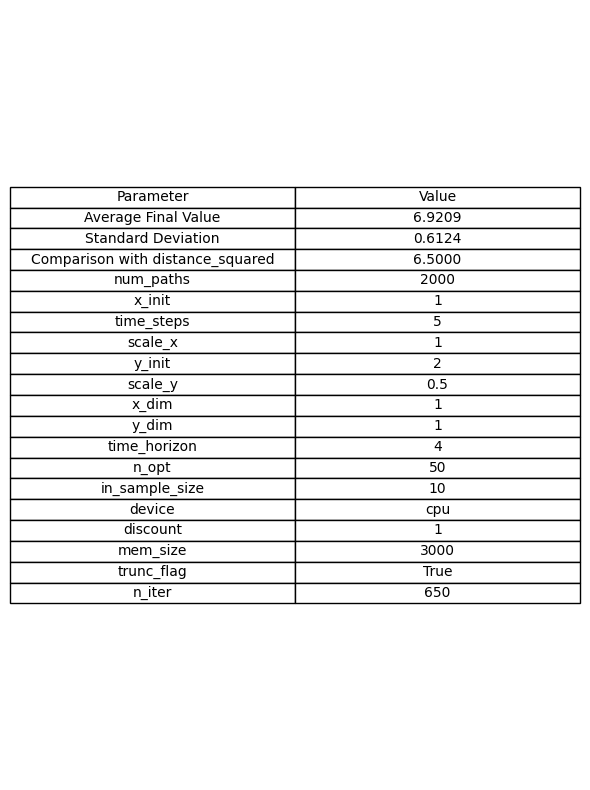

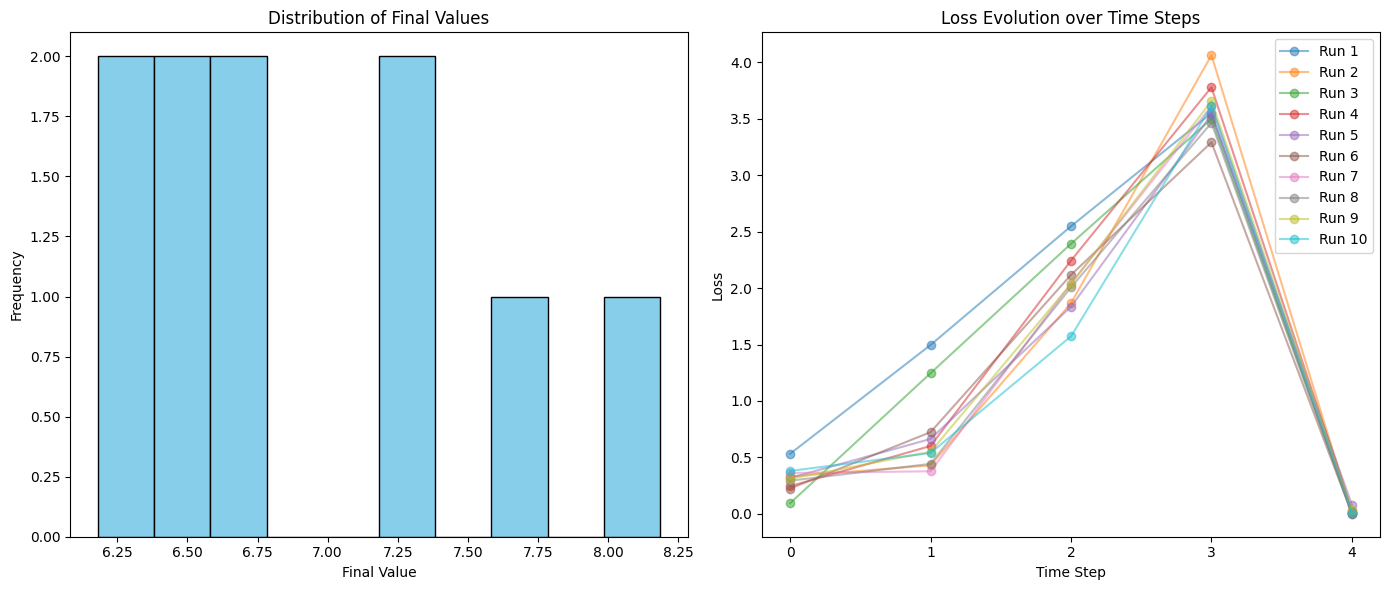

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Create a PNG table with the parameters and computed results
# -------------------------

# Prepare table data: computed values and the parameters used.
table_data = [
    ["Average Final Value", f"{mean_final_value:.4f}"],
    ["Standard Deviation", f"{std_final_value:.4f}"],
    ["Comparison with distance_squared", f"{distance_squared:.4f}"],
    # Brownian motion parameters:
    ["num_paths", f"{n_data}"],
    ["x_init", f"{x_init}"],
    ["time_steps", f"{time_steps}"],
    ["scale_x", f"{scale_x}"],
    ["y_init", f"{y_init}"],
    ["scale_y", f"{scale_y}"],
    # DQN training parameters:
    ["x_dim", "1"],
    ["y_dim", "1"],
    ["time_horizon", f"{time_steps - 1}"],
    ["n_opt", "50"],
    ["in_sample_size", "10"],
    ["device", f"{device}"],
    ["discount", "1"],
    ["mem_size", "3000"],
    ["trunc_flag", "True"],
    ["n_iter", "650"],
]

# Create a figure for the table.
fig_table, ax_table = plt.subplots(figsize=(6, 8))
ax_table.axis("tight")
ax_table.axis("off")
table = ax_table.table(
    cellText=table_data,
    colLabels=["Parameter", "Value"],
    cellLoc="center",
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
fig_table.tight_layout()
plt.savefig("results_table.png", bbox_inches="tight")
plt.show()

# -------------------------
# Plot the distribution of final values and the loss evolution (w.r.t. time steps)
# -------------------------

fig, (ax_hist, ax_loss) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram of final values.
ax_hist.hist(final_values, bins=10, color="skyblue", edgecolor="black")
ax_hist.set_title("Distribution of Final Values")
ax_hist.set_xlabel("Final Value")
ax_hist.set_ylabel("Frequency")

# Plot the loss history for each run with respect to time steps (0 to 4)
# Assume that each loss_hist in loss_histories has a length corresponding to the number of time steps (e.g., 5)
time_steps_axis = np.arange(0, 5)  # Time steps: 0, 1, 2, 3, 4
for i in range(num_runs):
    ax_loss.plot(
        time_steps_axis, loss_histories[i], marker="o", alpha=0.5, label=f"Run {i+1}"
    )

ax_loss.set_title("Loss Evolution over Time Steps")
ax_loss.set_xlabel("Time Step")
ax_loss.set_ylabel("Loss")
ax_loss.set_xticks(time_steps_axis)
ax_loss.legend()

plt.tight_layout()
plt.savefig("loss_and_final_values.png", bbox_inches="tight")
plt.show()

Time step 0 Loss: 0.011350940124611953
Final value at time 0: 4.033431529998779
Average Final Value: 6.2064
Standard Deviation: 1.9991
Comparison with distance_squared: 6.5000

2000 sample path n_opt = 20, in_sample size = 10

In [ ]:
from FVI import train_dqn_instance_no_outlier

# Number of runs
num_runs = 10

# Store results
final_values = []
val_histories = []
loss_histories = []

n_data = 2100  # to account for outlier dsicard

# Run the function multiple times
for i in range(num_runs):
    print("-----------------------------------------------")
    print(f"Run: {i:.4f}")
    x_paths = generate_brownian_motion(
        num_paths=n_data, x_init=x_init, time_steps=time_steps, scale=scale_x
    )
    y_paths = generate_brownian_motion(
        num_paths=n_data, x_init=y_init, time_steps=time_steps, scale=scale_y
    )
    final_value, val_hist, loss_hist = train_dqn_instance_no_outlier(
        x_dim=1,
        y_dim=1,
        time_horizon=time_steps - 1,
        samplepath_x=x_paths,
        samplepath_y=y_paths,
        n_opt=50,
        in_sample_size=40,
        device=device,
        discount=1,
        mem_size=3000,
        trunc_flag=True,
        n_iter=750,
    )

    final_values.append(final_value)
    val_histories.append(val_hist)
    loss_histories.append(loss_hist)

# Compute statistics
final_values = np.array(final_values)
mean_final_value = np.mean(final_values)
std_final_value = np.std(final_values)


# Print results
print(f"Average Final Value: {mean_final_value:.4f}")
print(f"Standard Deviation: {std_final_value:.4f}")
print(f"Comparison with distance_squared: {distance_squared:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Create a PNG table with the parameters and computed results
# -------------------------

# Prepare table data: computed values and the parameters used.
table_data = [
    ["Average Final Value", f"{mean_final_value:.4f}"],
    ["Standard Deviation", f"{std_final_value:.4f}"],
    ["Comparison with distance_squared", f"{distance_squared:.4f}"],
    # Brownian motion parameters:
    ["num_paths", f"{n_data}"],
    ["x_init", f"{x_init}"],
    ["time_steps", f"{time_steps}"],
    ["scale_x", f"{scale_x}"],
    ["y_init", f"{y_init}"],
    ["scale_y", f"{scale_y}"],
    # DQN training parameters:
    ["x_dim", "1"],
    ["y_dim", "1"],
    ["time_horizon", f"{time_steps - 1}"],
    ["n_opt", "50"],
    ["in_sample_size", "10"],
    ["device", f"{device}"],
    ["discount", "1"],
    ["mem_size", "3000"],
    ["trunc_flag", "True"],
    ["n_iter", "650"],
]

# Create a figure for the table.
fig_table, ax_table = plt.subplots(figsize=(6, 8))
ax_table.axis("tight")
ax_table.axis("off")
table = ax_table.table(
    cellText=table_data,
    colLabels=["Parameter", "Value"],
    cellLoc="center",
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
fig_table.tight_layout()
plt.savefig("results_table.png", bbox_inches="tight")
plt.show()

# -------------------------
# Plot the distribution of final values and the loss evolution (w.r.t. time steps)
# -------------------------

fig, (ax_hist, ax_loss) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram of final values.
ax_hist.hist(final_values, bins=10, color="skyblue", edgecolor="black")
ax_hist.set_title("Distribution of Final Values")
ax_hist.set_xlabel("Final Value")
ax_hist.set_ylabel("Frequency")

# Plot the loss history for each run with respect to time steps (0 to 4)
# Assume that each loss_hist in loss_histories has a length corresponding to the number of time steps (e.g., 5)
time_steps_axis = np.arange(0, 5)  # Time steps: 0, 1, 2, 3, 4
for i in range(num_runs):
    ax_loss.plot(
        time_steps_axis, loss_histories[i], marker="o", alpha=0.5, label=f"Run {i+1}"
    )

ax_loss.set_title("Loss Evolution over Time Steps")
ax_loss.set_xlabel("Time Step")
ax_loss.set_ylabel("Loss")
ax_loss.set_xticks(time_steps_axis)
ax_loss.legend()

plt.tight_layout()
plt.savefig("loss_and_final_values.png", bbox_inches="tight")
plt.show()